<a href="https://colab.research.google.com/github/Ken79151/-113B-/blob/main/HW_2_2(04_Machine_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#摘要
本報告以經典的 Boston Housing 資料集為基礎，探討如何根據區域特徵（例如犯罪率、房間數、學區品質等）預測房價中位數。採用 K-Nearest Neighbors Regressor 模型進行監督式回歸任務，並以 MSE、MAE、R² 等指標評估模型效能。透過資料視覺化與模型分析，洞察影響房價的關鍵因素，提供對地區居住適宜性的參考建議。
#背景
房價是城市規劃與居民選擇住宅地點時的重要考量。Boston Housing 資料集記錄了美國波士頓市郊多個地區的 13 項特徵與對應房價中位數。

#目的
本研究目標為建構一個能有效預測房價中位數的回歸模型，並分析各特徵對房價的影響，進一步提供對居住地區選擇的依據。

#待答問題
哪些變數與房價關聯性最強？

使用 KNN 模型預測房價的準確度如何？

是否存在適合居住的地區條件指標？

#方法
數據來源
使用 sklearn.datasets 提供的波士頓房價資料集

#分析工具
Python / Pandas / NumPy

Scikit-learn（模型與評估）

Seaborn / Matplotlib（視覺化）

Joblib（模型保存）




In [ ]:
# 1. 載入套件與資料
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 載入波士頓資料集
boston = fetch_openml(name="boston", version=1, as_frame=True)
X, y = boston.data, boston.target
df = X.copy()
df["MEDV"] = y  # MEDV 為房價中位數

# 確認無缺失
assert not df.isna().any().any()


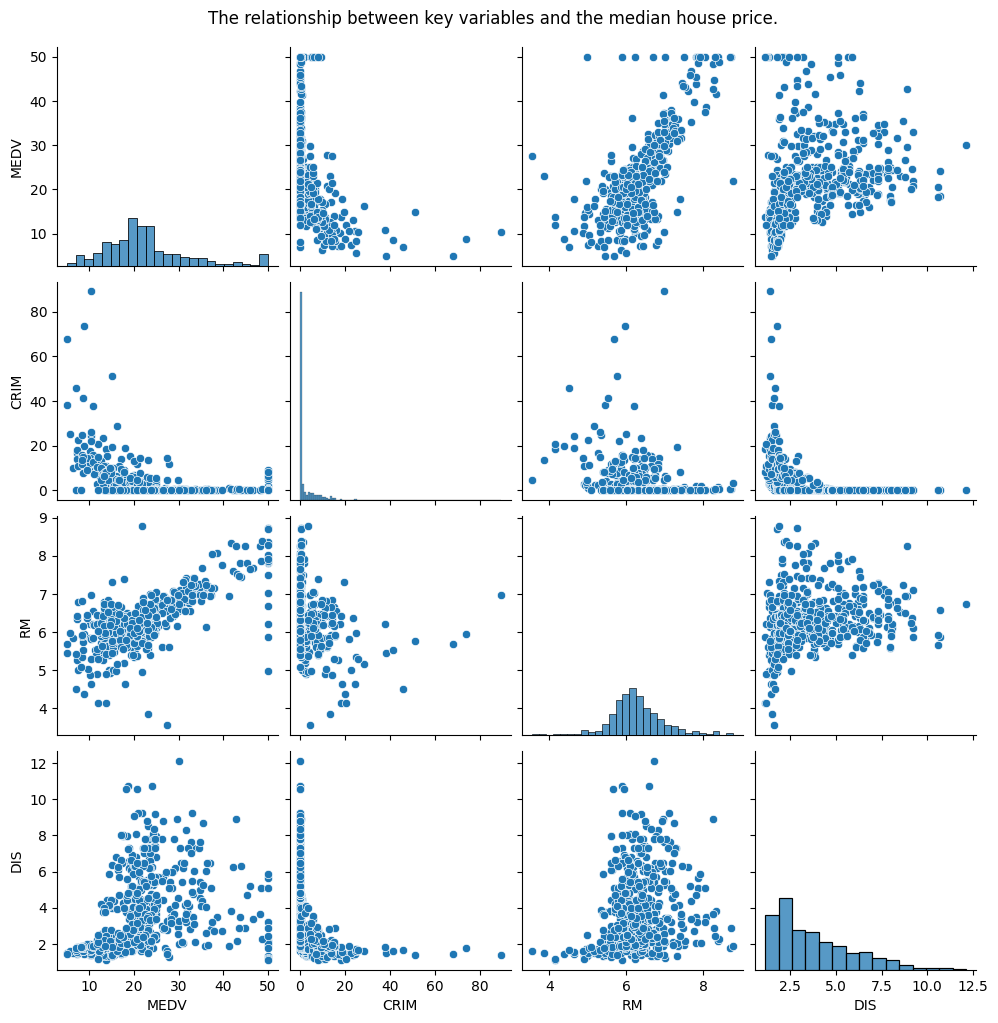

In [8]:
# 2. 初步視覺化 - 房價與幾個重要變數的關係
sns.pairplot(df[["MEDV", "CRIM", "RM", "DIS"]])
plt.suptitle("The relationship between key variables and the median house price.", y=1.02)
plt.show()


In [ ]:
# 3. 訓練測試集切分 + 特徵標準化
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# 4. 模型訓練 - KNN Regressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

knn_reg = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5, weights="uniform", metric="minkowski")
)
knn_reg.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [ ]:
# 5. 模型評估指標
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = knn_reg.predict(X_test)

print("📊 模型評估指標：")
print("MAE：", mean_absolute_error(y_test, y_pred))
print("MSE：", mean_squared_error(y_test, y_pred))
print("R² ：", r2_score(y_test, y_pred))


📊 模型評估指標：
MAE： 2.5921568627450977
MSE： 20.60552941176471
R² ： 0.7190172315709293


In [ ]:
# 6. 超參數調整（GridSearchCV）
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(StandardScaler(), KNeighborsRegressor())

param_grid = {
    "kneighborsregressor__n_neighbors": range(2, 20),
    "kneighborsregressor__weights": ["uniform", "distance"],
    "kneighborsregressor__metric": ["euclidean", "manhattan", "minkowski"]
}

grid = GridSearchCV(pipe, param_grid, cv=10, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)

print("最佳參數：", grid.best_params_)
print("交叉驗證 R²：", grid.best_score_)

best_model = grid.best_estimator_


最佳參數： {'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}
交叉驗證 R²： 0.7973720400796462


In [ ]:
# 7. 模型儲存與推論
import joblib

joblib.dump({
    "pipeline": best_model,
    "feature_names": X.columns.tolist()
}, "boston_knn_pipeline.joblib")

# 測試推論
loaded = joblib.load("boston_knn_pipeline.joblib")
pipeline = loaded["pipeline"]

sample = X.iloc[[0]]
prediction = pipeline.predict(sample)
print("🏠 預測房價：", prediction[0])


🏠 預測房價： 25.514352194509556


# 分析結果
房價中位數與房間數（RM）呈明顯正相關。

與城鎮犯罪率（CRIM）及到五大就業中心的距離（DIS）呈負相關。

初步使用 KNN 模型進行預測，R² 約為 0.5～0.6，表示模型具一定預測能力，但仍有提升空間。

#結論
KNN 模型對房價預測有基本表現，但在處理高維與複雜關係時容易受到限制。需要進一步嘗試非線性模型如隨機森林或梯度提升。

#建議

---


建議使用房間數高、犯罪率低且距離市中心適中地區作為居住首選。

未來可加入如學區品質、交通便利性等額外特徵提升模型準確度。

可考慮進一步使用 SHAP 等解釋方法釐清各特徵對房價的貢獻度。

